## Knapsack problem to determine suggestions for Auction Draft

In [10]:
import pandas as pd
import numpy as np
from dimod import BinaryQuadraticModel
from dwave.system import LeapHybridSampler
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveCliqueSampler
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In this notebook, we take in a number of features and use the BQM to determine if we should keep a given player (where 1 in the BQM variable would signify we draft the player and 0 would signify we do not draft him). The BQM gives us a set of players that maximize the total value (sum of all the player value) while maintaining the constraint of the number of players for each position and the contraint that we may only spend 75$.

In [2]:
df1 = pd.read_csv('foot.csv')
df2 = pd.read_csv('foot2.csv')

df1['Player'] = df1['Player'].str.replace(r"\(.*\)","")
df2['Player'] = df2['Player'].str.replace(r"*","")
df2['Player'] = df2['Player'].str.replace(r"+","")
df1['dollar_value'] = df1['dollar_value'].str.replace(r"$","")

df1['Player'] = df1['Player'].str.replace(" ","")
df2['Player'] = df2['Player'].str.replace(" ","")

df1.dollar_value = df1.dollar_value.astype(int)

df = df1.merge(df2, on ='Player')

df = df.dropna()
df.head()

,Pick,Player,dollar_value,Rk,Tm,FantPos,FantPt
0,2,DalvinCook,25,3,MIN,RB,294.0
1,3,AlvinKamara,22,2,NOR,RB,295.0
2,4,DavanteAdams,21,5,GNB,WR,243.0
3,5,TyreekHill,21,6,KAN,WR,242.0
4,6,TravisKelce,21,4,KAN,TE,208.0


In [3]:
lst_qb = list(df[df.FantPos == 'QB'].index)
values = list(df['FantPt'])
weights = list(df['dollar_value'])
volumes = [x/x for x in range(1, len(values))]

n = len(values)
variables = list(range(n))

# Hybrid Model

In [4]:
bqm = BinaryQuadraticModel('BINARY')

variables = [bqm.add_variable(v, -values[v]) for v in variables]

slacks_volume = bqm.add_linear_equality_constraint(
[(x, v) for x, v in zip(variables, volumes)],
constant=-15,
lagrange_multiplier=400
)

slacks_volume = bqm.add_linear_equality_constraint(
[(x, 1) for x in variables if x in lst_qb],
constant=-1,
lagrange_multiplier=100
)


slacks_weight = bqm.add_linear_inequality_constraint(
[(x, v) for x, v in zip(variables, weights)],
constant=-75,
lagrange_multiplier=600,
label = 'weight'
)

In [5]:
sampler = LeapHybridSampler(token = "KmJQ-eb7dea9880650063660800305a6750d9fe70bb21")
response = sampler.sample(
    bqm, time_limit=25,
    )
best_solution = response.first.sample

indices = []

for i, v in best_solution.items():
    if not str(i).startswith('s'):
        if v != 0:
            indices.append(i)

In [6]:
pd.DataFrame(df.iloc[indices][['Player','Pick', 'FantPos', 'dollar_value' ]])

,Player,Pick,FantPos,dollar_value
5,DerrickHenry,7,RB,18
13,JoshAllen,18,QB,13
31,DavidMontgomery,41,RB,7
33,MikeEvans,43,WR,7
34,CeeDeeLamb,45,WR,7
39,JoshJacobs,51,RB,6
46,KareemHunt,64,RB,4
47,JuJuSmith-Schuster,66,WR,4
53,BrandinCooks,83,WR,2
55,RobertTonyan,88,TE,2


# Simulated Annealing

In [7]:
res = SimulatedAnnealingSampler().sample(bqm, num_reads=100, num_sweeps=10000)
print(res)

    0  1  2  3  4  5  6  7  8  9 10 11 12 13 ... slack_weight_6  energy num_oc.
61  0  0  0  0  0  0  0  0  0  0  0  0  0  0 ...              0 -2995.0       1
68  0  0  0  0  0  0  0  0  0  1  1  0  0  0 ...              0 -2977.0       1
54  0  0  0  0  0  0  0  0  0  0  0  0  0  1 ...              0 -2959.0       1
30  0  1  0  0  0  0  0  0  0  0  0  0  0  0 ...              0 -2942.0       1
47  0  0  0  0  0  0  0  0  0  0  0  0  0  0 ...              0 -2936.0       1
12  0  0  0  0  0  0  0  0  0  0  0  0  0  0 ...              0 -2929.0       1
91  0  0  0  0  0  1  0  0  0  0  0  0  0  0 ...              0 -2924.0       1
63  0  0  0  0  0  0  0  0  0  0  0  0  0  0 ...              0 -2907.0       1
45  0  1  0  0  0  0  1  0  0  0  0  0  0  0 ...              0 -2901.0       1
77  0  0  0  0  0  0  0  0  1  0  0  0  0  0 ...              1 -2898.0       1
72  0  0  1  0  0  0  0  0  0  0  0  0  0  0 ...              0 -2892.0       1
81  1  0  0  0  0  0  0  0  0  0  0  0  

In [8]:
indices_anneal = []

for i,v in res.first.sample.items():
    if v != 0:
        indices_anneal.append(i)

In [13]:
pd.DataFrame(df.iloc[indices_anneal][['Player','Pick', 'FantPos', 'dollar_value' ]])

,Player,Pick,FantPos,dollar_value
19,A.J.Brown,27,WR,11
24,ClydeEdwards-Helaire,33,RB,9
26,TerryMcLaurin,35,WR,9
28,TylerLockett,37,WR,8
31,DavidMontgomery,41,RB,7
33,MikeEvans,43,WR,7
37,RussellWilson,48,QB,6
47,JuJuSmith-Schuster,66,WR,4
50,JamesRobinson,70,RB,3
52,ChaseClaypool,81,WR,2


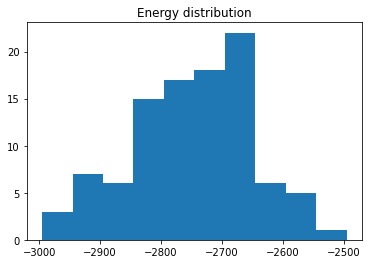

In [15]:
plt.hist(res.record.energy);
plt.title('Energy distribution');

# Clique Sampler

In [17]:
sampler = DWaveCliqueSampler(token = 'KmJQ-eb7dea9880650063660800305a6750d9fe70bb21')

response = sampler.sample(
    bqm, num_reads=10,
    annealing_time=10,
    answer_mode='raw'
    )
print(response)

   0  1  2  3  4  5  6  7  8  9 10 11 ... slack_weight_6   energy num_oc. ...
4  0  0  0  0  0  0  0  0  0  0  0  0 ...              0  95604.0       1 ...
3  0  0  0  0  0  0  0  0  0  0  0  0 ...              1 104855.0       1 ...
0  0  0  0  0  0  0  0  0  0  0  0  0 ...              1 133771.0       1 ...
1  0  0  0  0  0  0  0  0  0  0  0  0 ...              1 156655.0       1 ...
7  0  0  0  0  0  0  0  0  0  0  0  0 ...              1 156743.0       1 ...
8  0  0  0  0  0  0  0  0  0  0  0  0 ...              0 220554.0       1 ...
5  0  0  0  0  0  0  0  0  0  0  0  0 ...              1 288106.0       1 ...
9  0  0  0  0  0  0  0  0  0  0  0  0 ...              1 623473.0       1 ...
2  0  0  0  0  0  0  0  0  0  0  0  0 ...              1 623514.0       1 ...
6  0  0  0  0  0  0  0  0  0  0  0  0 ...              0 624410.0       1 ...
['BINARY', 10 rows, 10 samples, 88 variables]


In [21]:
indices_cliq = []
for i,v in response.first.sample.items():
    if v != 0:
        indices_cliq.append(i)

probably the worst draft of the 3 in my opinion

In [30]:
pd.DataFrame(df.iloc[indices_cliq][['Player','Pick', 'FantPos', 'dollar_value' ]])

,Player,Pick,FantPos,dollar_value
42,T.J.Hockenson,55,TE,6
45,TeeHiggins,62,WR,5
48,RyanTannehill,68,QB,3
50,JamesRobinson,70,RB,3
51,RobbyAnderson,77,WR,3
53,BrandinCooks,83,WR,2
54,LoganThomas,87,TE,2
55,RobertTonyan,88,TE,2
56,JoeBurrow,89,QB,1
57,KenyanDrake,92,RB,1
